In [1]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import chain
import pandas as pd
import datetime
import time
import os
import geopy.distance
import math
import sklearn.neighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def list_slicer (l:list,c1:int,c2:int):
    # slice a non-numpy 2d list from column 1 (c1) to column 2 (c2)
    # return a 2d sublist
    result = []
    for row in l:
        result.append(row[c1:c2])
    return result


def getDateRangeFromWeek(p_year,p_week):
    '''
    # get week start & end date
    # in YYYYMMDD format
    '''
    start = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    f = start + datetime.timedelta(days=1) # otherwise first day of wk1 is last day of Dec
    l = f + datetime.timedelta(days=6.9)
    firstday = 10000*f.year+100*f.month + f.day
    lastday = 10000*l.year+100*l.month + l.day
    return firstday, lastday

#Call function to get dates range 
firstdate, lastdate =  getDateRangeFromWeek('2013','1')
print('print function ',firstdate,' ', lastdate)

print function  20130101   20130107


## Query by Station

In [3]:
# convert station list to array
# there should be better ways but I didn't find any...
rows, cols = (119503, 9)
Stations= [[0 for i in range(cols)] for j in range(rows)]
with open('ghcnd-stations.txt','r') as f:
    s = f.readlines()
i = 0
for station in s:
    Stations[i][0]=station[:11] #ID
    Stations[i][1]=float(station[12:20]) # Latitude
    Stations[i][2]=float(station[21:30]) # Lontitude
    Stations[i][3]=float(station[31:37]) # Elevatioin
    Stations[i][4]=station[38:40].strip() # state
    Stations[i][5]=station[41:71].strip() # name
    Stations[i][6]=station[72:75].strip() # GSN flag
    Stations[i][7]=station[76:79].strip() # HCN/CRN flag
    WMO = station[80:85].strip()
    if len(WMO)>0:
        Stations[i][8]=int(WMO) # WMO ID
    else:
        Stations[i][8]=""
    i +=1


In [4]:
# Station_df as the station dataframe
my_states = ['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
             'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
             'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ',
             'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
             'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
#No Alaska or Hawaii

cols = ["ID","Latitude","Longtitude","Elevation","State","Name","GSN","HCN/CRN","WMO"]
Station_df = pd.DataFrame (Stations, columns = cols)
Station_df.set_index('ID')
Station_df = Station_df[["ID","Latitude","Longtitude","Elevation","State","Name"]]
Station_df = Station_df.query('State==@my_states')
#Station_df.style.set_properties(subset="Name",**{'text-align': 'left'})
Station_df.head()

ID  Latitude  Longtitude  Elevation State  \
52607  US009052008   43.7333    -96.6333      482.0    SD   
52608  US10RMHS145   40.5268   -105.1113     1569.1    CO   
52609  US10adam001   40.5680    -98.5069      598.0    NE   
52610  US10adam002   40.5093    -98.5493      601.1    NE   
52611  US10adam003   40.4663    -98.6537      615.1    NE   

                                Name  
52607  SIOUX FALLS (ENVIRON. CANADA)  
52608                   RMHS 1.6 SSW  
52609                  JUNIATA 1.5 S  
52610                JUNIATA 6.0 SSW  
52611                HOLSTEIN 0.1 NW

In [8]:
filename_snow = "SNOW.csv"
filename_prcp = "PRCP.csv"
filename_temp = "TAVG.csv"

cols_snow = ['ID', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 
             'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 
             'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 
             'S34', 'S35', 'S36', 'S37', 'S38', 'S39', 'S40', 'S41', 'S42', 'S43', 'S44', 
             'S45', 'S46', 'S47', 'S48', 'S49', 'S50', 'S51', 'S52', 'S53']

cols_prcp = ['ID', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 
             'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 
             'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 
             'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 
             'P45', 'P46', 'P47', 'P48', 'P49', 'P50', 'P51', 'P52', 'P53']

cols_temp = ['ID', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11',
             'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 
             'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 
             'T34', 'T35', 'T36', 'T37', 'T38', 'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 
             'T45', 'T46', 'T47', 'T48', 'T49', 'T50', 'T51', 'T52', 'T53']

df_s1 = pd.read_csv(filename_snow, names = cols_snow, low_memory=False).iloc[:][3:].set_index('ID')
df_p1 = pd.read_csv(filename_prcp, names = cols_prcp, low_memory=False).iloc[:][3:].set_index('ID')
df_t1 = pd.read_csv(filename_temp, names = cols_temp, low_memory=False).iloc[:][3:].set_index('ID')

In [9]:
df_s1.head()

S1   S2   S3   S4   S5   S6   S7   S8   S9  S10  ...  S44  S45  \
ID                                                             ...             
AQC00914000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
AQW00061705  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
BF1BI000001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
BF1CE000001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
BF1CE000005  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

             S46  S47  S48  S49  S50  S51  S52  S53  
ID                                                   
AQC00914000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AQW00061705  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
BF1BI000001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  
BF1CE000001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  
BF1CE000005  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  

[5 rows x 53 columns]

In [10]:
df_p1.head()

P1                  P2                 P3  \
ID                                                                      
AE000041196               34.0   42.36363636363637  20.46153846153846   
AEM00041194  6.777777777777778               62.45  85.77777777777777   
AEM00041217                0.0   94.71428571428572              195.0   
AEM00041218                NaN  388.66666666666674               98.6   
AFM00040938              232.5               495.5               45.5   

                             P4                 P5                 P6  \
ID                                                                      
AE000041196  21.416666666666668               34.0  5.454545454545454   
AEM00041194   16.11111111111111  4.222222222222221  6.833333333333332   
AEM00041217   20.33333333333333               10.0  8.333333333333334   
AEM00041218               115.5               16.5  24.66666666666667   
AFM00040938               718.5  335.6666666666667              923.5   

                            P7                  P8                 P9  \
ID                                                                      
AE000041196  2.333333333333333                17.0               32.2   
AEM00041194  5.166666666666667  20.263157894736842  32.68421052631579   
AEM00041217                0.0   26.33333333333333  76.16666666666667   
AEM00041218                1.0                84.0               36.2   
AFM00040938              560.0   57.33333333333334               89.5   

                            P10  ...                P44                 P45  \
ID                               ...                                          
AE000041196  1.3333333333333333  ...  3.272727272727273               37.25   
AEM00041194  0.7894736842105263  ...              0.375  0.7647058823529411   
AEM00041217                26.5  ...                NaN                 5.0   
AEM00041218                 NaN  ...                NaN                 NaN   
AFM00040938               200.5  ...  517.6666666666666                 0.0   

                           P46                 P47                 P48  \
ID                                                                       
AE000041196                0.0  10.444444444444443   47.92307692307693   
AEM00041194  18.41176470588235   20.47058823529412  12.294117647058822   
AEM00041217                NaN                25.0  2.6666666666666665   
AEM00041218                NaN                36.0                 NaN   
AFM00040938  8.333333333333334               449.5               190.5   

                            P49                 P50                 P51  \
ID                                                                        
AE000041196   78.36363636363636                95.8  16.416666666666668   
AEM00041194  61.411764705882355   44.27777777777778  18.894736842105264   
AEM00041217  12.666666666666664  195.33333333333331                11.6   
AEM00041218                 8.0               681.0                 5.0   
AFM00040938               495.0  145.33333333333334                76.0   

                           P52                P53  
ID                                                 
AE000041196  29.09090909090909                0.0  
AEM00041194  18.33333333333333  7.611111111111112  
AEM00041217               25.0               36.0  
AEM00041218                NaN                NaN  
AFM00040938              731.5               20.0  

[5 rows x 53 columns]

In [11]:
df_t1.head()

T1                  T2                  T3  \
ID                                                                        
AE000041196  1161.2272727272727  1328.7727272727273  1282.2272727272727   
AEM00041194  1247.2272727272727   1444.090909090909  1382.3181818181818   
AEM00041217   1182.909090909091  1377.9545454545455   1316.909090909091   
AEM00041218  1145.1818181818182  1318.4545454545455   1244.409090909091   
AFM00040938            323.6875            301.1875             279.125   

                             T4                  T5                  T6  \
ID                                                                        
AE000041196   1291.409090909091              1343.0   1331.909090909091   
AEM00041194  1388.7272727272727  1429.1818181818182   1431.090909090909   
AEM00041217  1326.1818181818182  1378.1818181818182  1370.1363636363635   
AEM00041218  1282.3636363636365  1338.3636363636365   1347.409090909091   
AFM00040938               394.0            483.4375            433.5625   

                             T7                  T8                  T9  \
ID                                                                        
AE000041196  1407.8636363636365  1456.1818181818182   1523.409090909091   
AEM00041194  1498.0454545454545   1538.409090909091  1592.0454545454545   
AEM00041217   1451.409090909091  1490.3636363636365  1557.7727272727273   
AEM00041218              1450.0              1503.5  1567.3181818181818   
AFM00040938            513.6875             628.875              702.75   

                            T10  ...                 T44                 T45  \
ID                               ...                                           
AE000041196  1512.7272727272727  ...  1929.6818181818185  1837.3636363636365   
AEM00041194  1581.7272727272727  ...  2044.2727272727273  1946.6363636363642   
AEM00041217  1538.5454545454545  ...  1982.1363636363642  1892.4545454545453   
AEM00041218  1578.3636363636365  ...              1981.5  1863.1818181818185   
AFM00040938            816.1875  ...   961.6666666666665               889.2   

                            T46                 T47                 T48  \
ID                                                                        
AE000041196  1743.8181818181818  1676.4545454545455  1608.8636363636365   
AEM00041194  1863.4545454545453  1779.2272727272727  1705.1363636363635   
AEM00041217  1795.6363636363635  1719.2272727272727  1648.2727272727273   
AEM00041218  1762.4545454545455  1665.0454545454545  1588.8181818181818   
AFM00040938   747.0666666666667            641.3125            525.0625   

                            T49                 T50                 T51  \
ID                                                                        
AE000041196  1544.3636363636365  1494.1818181818182              1424.0   
AEM00041194  1652.6818181818182  1599.1818181818182  1534.7272727272727   
AEM00041217  1584.3636363636365   1531.409090909091  1458.1818181818182   
AEM00041218   1544.090909090909  1464.8181818181818  1397.9545454545455   
AFM00040938            592.6875             411.125            407.6875   

                            T52                 T53  
ID                                                   
AE000041196  1394.1363636363635   432.2272727272728  
AEM00041194   1496.409090909091   470.9090909090909  
AEM00041217  1421.2727272727273  445.27272727272725  
AEM00041218  1357.3181818181818   429.6363636363636  
AFM00040938            391.8125             94.3125  

[5 rows x 53 columns]

### This looks great, and the unit of precipitation is 1/10th of a mm, however we do have NaN values, so we will first cut all stations with NaNs

In [12]:
X = df_p1.values[:, 1:].astype(float)
X_num = np.nan_to_num(X).astype(int)
print(X_num)

[[ 42  20  21 ...  16  29   0]
 [ 62  85  16 ...  18  18   7]
 [ 94 195  20 ...  11  25  36]
 ...
 [345 302 251 ... 555 546 189]
 [242 273 245 ... 249 220 178]
 [445 362 296 ... 255 303 220]]


## Run a KMeans Model using just Precipitation

In [13]:
num_clust = 20

kmeans_X = KMeans(n_clusters=num_clust, random_state=0).fit(X_num)
kmeans_labels = kmeans_X.labels_
print(kmeans_labels)

[ 8  8  8 ... 14  4  4]


In [20]:
import sklearn
sklearn.metrics.silhouette_score(X_num, kmeans_labels, metric='euclidean', sample_size=None, random_state=42)

0.048623000577610265

In [14]:
cluster_IDs = df_p1.index.tolist()
cluster_IDs_list = []
for i in cluster_IDs:
    cluster_IDs_list.append(i)
    
print(cluster_IDs_list)

['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938', 'AFM00040948', 'AFM00040990', 'AG000060390', 'AG000060590', 'AG000060611', 'AG000060680', 'AGE00147708', 'AGE00147710', 'AGE00147716', 'AGE00147718', 'AGE00147719', 'AGM00060351', 'AGM00060353', 'AGM00060355', 'AGM00060360', 'AGM00060367', 'AGM00060369', 'AGM00060387', 'AGM00060402', 'AGM00060403', 'AGM00060405', 'AGM00060410', 'AGM00060415', 'AGM00060417', 'AGM00060419', 'AGM00060421', 'AGM00060423', 'AGM00060425', 'AGM00060430', 'AGM00060437', 'AGM00060444', 'AGM00060445', 'AGM00060452', 'AGM00060457', 'AGM00060461', 'AGM00060467', 'AGM00060468', 'AGM00060471', 'AGM00060475', 'AGM00060476', 'AGM00060490', 'AGM00060506', 'AGM00060507', 'AGM00060511', 'AGM00060514', 'AGM00060515', 'AGM00060518', 'AGM00060520', 'AGM00060522', 'AGM00060531', 'AGM00060535', 'AGM00060536', 'AGM00060540', 'AGM00060549', 'AGM00060550', 'AGM00060555', 'AGM00060557', 'AGM00060559', 'AGM00060560', 'AGM00060563', 'AGM00060566', 'AGM00060

In [15]:
df_kmeans_labels = pd.DataFrame(list(zip(cluster_IDs_list, kmeans_labels)),
               columns =['ID', 'kmeans_labels'])
df_kmeans_labels.set_index('ID')
df_kmeans_labels.head()

ID  kmeans_labels
0  AE000041196              8
1  AEM00041194              8
2  AEM00041217              8
3  AEM00041218              8
4  AFM00040938             14

In [16]:
df_final = Station_df.set_index('ID').join(df_kmeans_labels.set_index('ID'))
df_final.head()

Latitude  Longtitude  Elevation State  \
ID                                                   
US009052008   43.7333    -96.6333      482.0    SD   
US10RMHS145   40.5268   -105.1113     1569.1    CO   
US10adam001   40.5680    -98.5069      598.0    NE   
US10adam002   40.5093    -98.5493      601.1    NE   
US10adam003   40.4663    -98.6537      615.1    NE   

                                      Name  kmeans_labels  
ID                                                         
US009052008  SIOUX FALLS (ENVIRON. CANADA)           17.0  
US10RMHS145                   RMHS 1.6 SSW            8.0  
US10adam001                  JUNIATA 1.5 S            1.0  
US10adam002                JUNIATA 6.0 SSW            1.0  
US10adam003                HOLSTEIN 0.1 NW            1.0

C:\Users\ankitk\Anaconda3\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\Users\ankitk\Anaconda3\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


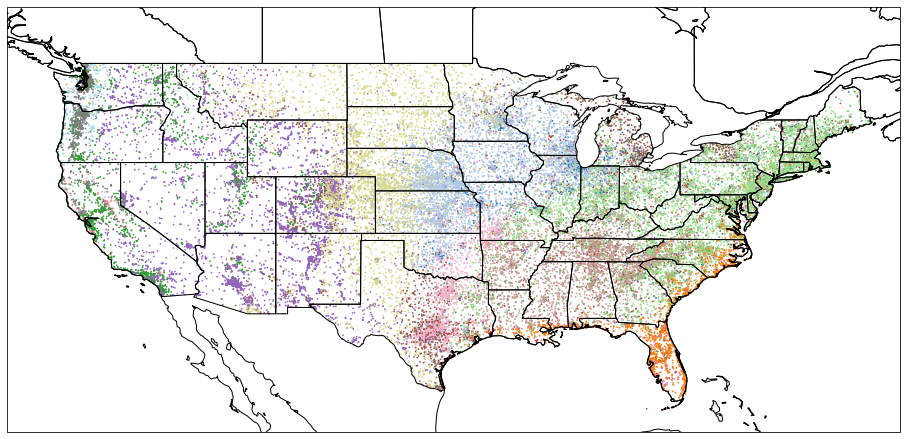

In [17]:
fig = plt.figure(figsize=(16,12))
m_usa = plt.axes(projection=ccrs.PlateCarree())
m_usa.set_extent([-128, -65, 23, 53], ccrs.PlateCarree())
m_usa.add_feature(cfeature.STATES)
m_usa.coastlines()

Lat = df_final["Latitude"].to_numpy()
Long = df_final["Longtitude"].to_numpy()
Labs = df_final["kmeans_labels"].to_numpy()

m_usa.scatter(Long, Lat, transform=ccrs.PlateCarree(), s=0.5, c=Labs, cmap="tab20")

# Now that we have proven our model can create useful clusters with just precipitation data, we can append temperature and snow data per week and create a new model

### Get Precipitation vectors for our model

In [68]:
XP = df_p1.values[:, 1:].astype(float)
XP_num = np.nan_to_num(X).astype(int)
print(XP_num)

[[ 42  20  21 ...  16  29   0]
 [ 62  85  16 ...  18  18   7]
 [ 94 195  20 ...  11  25  36]
 ...
 [345 302 251 ... 555 546 189]
 [242 273 245 ... 249 220 178]
 [445 362 296 ... 255 303 220]]


### Get Temperature vectors for our model

In [69]:
XT = df_t1.values[:, 1:].astype(float)
XT_num = np.nan_to_num(X).astype(int)
print(XT_num)

[[ 42  20  21 ...  16  29   0]
 [ 62  85  16 ...  18  18   7]
 [ 94 195  20 ...  11  25  36]
 ...
 [345 302 251 ... 555 546 189]
 [242 273 245 ... 249 220 178]
 [445 362 296 ... 255 303 220]]


### Get Snow vectors for our model

In [70]:
XS = df_s1.values[:, 1:].astype(float)
XS_num = np.nan_to_num(X).astype(int)
print(XP_num)

[[ 42  20  21 ...  16  29   0]
 [ 62  85  16 ...  18  18   7]
 [ 94 195  20 ...  11  25  36]
 ...
 [345 302 251 ... 555 546 189]
 [242 273 245 ... 249 220 178]
 [445 362 296 ... 255 303 220]]


### Append our Stations' precipitation, temp, and snow data horizontally

In [74]:
df_final = pd.concat([df_p1, df_t1, df_s1])
df_final

P1                  P2                 P3  \
ID                                                                      
AE000041196               34.0   42.36363636363637  20.46153846153846   
AEM00041194  6.777777777777778               62.45  85.77777777777777   
AEM00041217                0.0   94.71428571428572              195.0   
AEM00041218                NaN  388.66666666666674               98.6   
AFM00040938              232.5               495.5               45.5   
...                        ...                 ...                ...   
VQC00673677                NaN                 NaN                NaN   
VQC00674900                NaN                 NaN                NaN   
VQC00677600                NaN                 NaN                NaN   
VQC00679450                NaN                 NaN                NaN   
WQW00041606                NaN                 NaN                NaN   

                             P4                 P5                 P6  \
ID                                                                      
AE000041196  21.416666666666668               34.0  5.454545454545454   
AEM00041194   16.11111111111111  4.222222222222221  6.833333333333332   
AEM00041217   20.33333333333333               10.0  8.333333333333334   
AEM00041218               115.5               16.5  24.66666666666667   
AFM00040938               718.5  335.6666666666667              923.5   
...                         ...                ...                ...   
VQC00673677                 NaN                NaN                NaN   
VQC00674900                 NaN                NaN                NaN   
VQC00677600                 NaN                NaN                NaN   
VQC00679450                 NaN                NaN                NaN   
WQW00041606                 NaN                NaN                NaN   

                            P7                  P8                 P9  \
ID                                                                      
AE000041196  2.333333333333333                17.0               32.2   
AEM00041194  5.166666666666667  20.263157894736842  32.68421052631579   
AEM00041217                0.0   26.33333333333333  76.16666666666667   
AEM00041218                1.0                84.0               36.2   
AFM00040938              560.0   57.33333333333334               89.5   
...                        ...                 ...                ...   
VQC00673677                NaN                 NaN                NaN   
VQC00674900                NaN                 NaN                NaN   
VQC00677600                NaN                 NaN                NaN   
VQC00679450                NaN                 NaN                NaN   
WQW00041606                NaN                 NaN                NaN   

                            P10  ...  S44                 S45  S46  S47  S48  \
ID                               ...                                           
AE000041196  1.3333333333333333  ...  NaN                 NaN  NaN  NaN  NaN   
AEM00041194  0.7894736842105263  ...  NaN                 NaN  NaN  NaN  NaN   
AEM00041217                26.5  ...  NaN                 NaN  NaN  NaN  NaN   
AEM00041218                 NaN  ...  NaN                 NaN  NaN  NaN  NaN   
AFM00040938               200.5  ...  NaN                 NaN  NaN  NaN  NaN   
...                         ...  ...  ...                 ...  ...  ...  ...   
VQC00673677                 NaN  ...  0.0  1.6666666666666667  0.0  0.0  0.0   
VQC00674900                 NaN  ...  0.0                 0.0  0.0  0.0  0.0   
VQC00677600                 NaN  ...  0.0                 0.0  0.0  0.0  0.0   
VQC00679450                 NaN  ...  0.0                 0.0  0.0  0.0  0.0   
WQW00041606                 NaN  ...  0.0                 0.0  0.0  0.0  0.0   

             S49  S50  S51  S52  S53  
ID                                    
AE000041196  NaN  NaN  NaN  NaN  NaN  
AEM00041194  NaN  Na

In [75]:
X_final = df_final.values[:, 1:].astype(float)
X_final = np.nan_to_num(X).astype(int)
print(X_final)

[[ 42  20  21 ...  16  29   0]
 [ 62  85  16 ...  18  18   7]
 [ 94 195  20 ...  11  25  36]
 ...
 [345 302 251 ... 555 546 189]
 [242 273 245 ... 249 220 178]
 [445 362 296 ... 255 303 220]]


In [76]:
num_clust = 20

kmeans_X_final = KMeans(n_clusters=num_clust, random_state=0).fit(X_final)
kmeans_labels_final = kmeans_X_final.labels_
print(kmeans_labels_final)

[ 8  8  8 ... 14  4  4]


In [77]:
cluster_IDs_final = df_final.index.tolist()
cluster_IDs_list_final = []
for i in cluster_IDs_final:
    cluster_IDs_list_final.append(i)
    
print(cluster_IDs_list_final)

['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938', 'AFM00040948', 'AFM00040990', 'AG000060390', 'AG000060590', 'AG000060611', 'AG000060680', 'AGE00147708', 'AGE00147710', 'AGE00147716', 'AGE00147718', 'AGE00147719', 'AGM00060351', 'AGM00060353', 'AGM00060355', 'AGM00060360', 'AGM00060367', 'AGM00060369', 'AGM00060387', 'AGM00060402', 'AGM00060403', 'AGM00060405', 'AGM00060410', 'AGM00060415', 'AGM00060417', 'AGM00060419', 'AGM00060421', 'AGM00060423', 'AGM00060425', 'AGM00060430', 'AGM00060437', 'AGM00060444', 'AGM00060445', 'AGM00060452', 'AGM00060457', 'AGM00060461', 'AGM00060467', 'AGM00060468', 'AGM00060471', 'AGM00060475', 'AGM00060476', 'AGM00060490', 'AGM00060506', 'AGM00060507', 'AGM00060511', 'AGM00060514', 'AGM00060515', 'AGM00060518', 'AGM00060520', 'AGM00060522', 'AGM00060531', 'AGM00060535', 'AGM00060536', 'AGM00060540', 'AGM00060549', 'AGM00060550', 'AGM00060555', 'AGM00060557', 'AGM00060559', 'AGM00060560', 'AGM00060563', 'AGM00060566', 'AGM00060

In [78]:
df_kmeans_labels_final = pd.DataFrame(list(zip(cluster_IDs_list_final, kmeans_labels_final)),
               columns =['ID', 'kmeans_labels'])
df_kmeans_labels_final.set_index('ID')
df_kmeans_labels_final.head()

ID  kmeans_labels
0  AE000041196              8
1  AEM00041194              8
2  AEM00041217              8
3  AEM00041218              8
4  AFM00040938             14

In [79]:
df_final_final = Station_df.set_index('ID').join(df_kmeans_labels_final.set_index('ID'))
df_final_final.head()

Latitude  Longtitude  Elevation State  \
ID                                                   
US009052008   43.7333    -96.6333      482.0    SD   
US10RMHS145   40.5268   -105.1113     1569.1    CO   
US10adam001   40.5680    -98.5069      598.0    NE   
US10adam002   40.5093    -98.5493      601.1    NE   
US10adam003   40.4663    -98.6537      615.1    NE   

                                      Name  kmeans_labels  
ID                                                         
US009052008  SIOUX FALLS (ENVIRON. CANADA)           17.0  
US10RMHS145                   RMHS 1.6 SSW            8.0  
US10adam001                  JUNIATA 1.5 S            1.0  
US10adam002                JUNIATA 6.0 SSW            1.0  
US10adam003                HOLSTEIN 0.1 NW            1.0

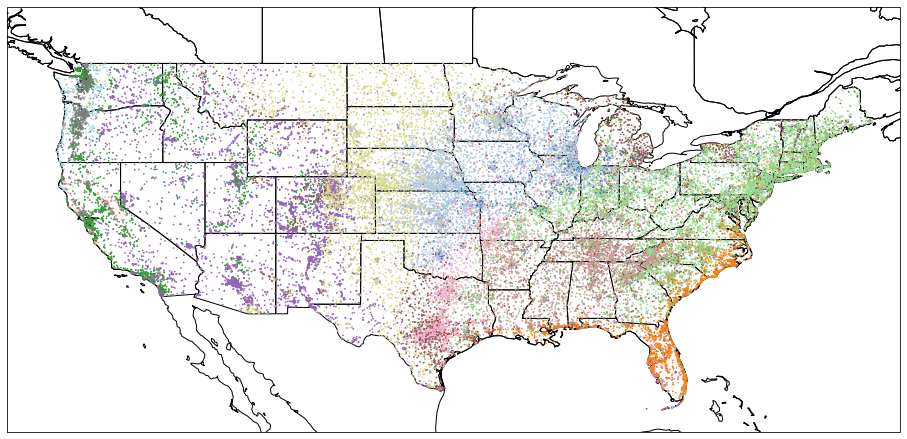

In [80]:
fig = plt.figure(figsize=(16,12))
m_usa = plt.axes(projection=ccrs.PlateCarree())
m_usa.set_extent([-128, -65, 23, 53], ccrs.PlateCarree())
m_usa.add_feature(cfeature.STATES)
m_usa.coastlines()

Lat  = df_final_final["Latitude"].to_numpy()
Long = df_final_final["Longtitude"].to_numpy()
Labs = df_final_final["kmeans_labels"].to_numpy()

m_usa.scatter(Long, Lat, transform=ccrs.PlateCarree(), s=0.5, c=Labs, cmap="tab20")